C:\Users\miron\AppData\Local\Temp\ipykernel_11960\843721261.py:103: RuntimeWarning: invalid value encountered in true_divide
  res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)


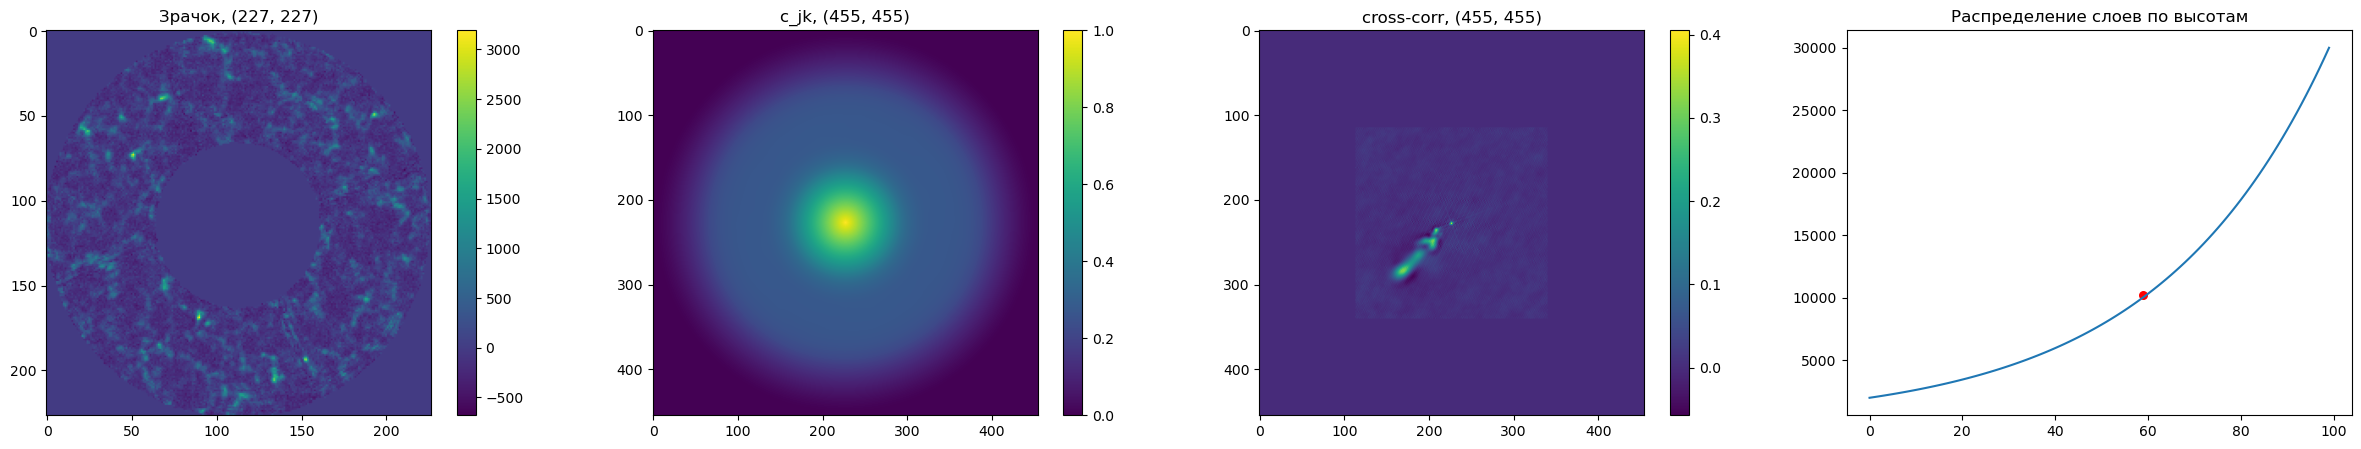

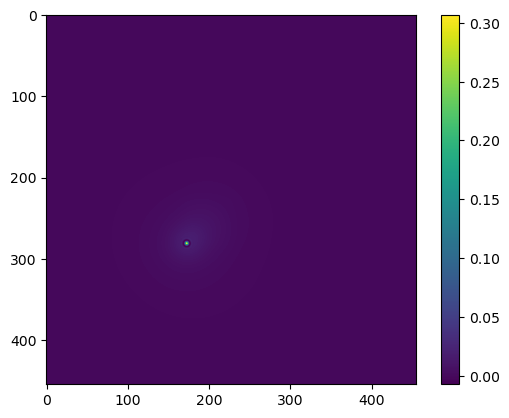

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from IPython.display import clear_output
from bisect import bisect_left

def take_closest(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0, 0
    if pos == len(myList):
        return -1, -1
    if pos != 0:
        before = myList[pos - 1]
        after = myList[pos]
        return np.argwhere(myList==after)[0][0], np.argwhere(myList==before)[0][0]


def sfilter(z=None):
    global nx, res_fft, omega_new_tmp
#     omega = z * omega_tmp # аргумент, шаг по частоте, [м^-1]
    omega_new = np.interp(z * omega_tmp, omega_new_tmp, res_fft)
    omega_new = np.resize(omega_new, (nx, nx))
    return omega_new

def c_jk(data, Dpix):
    nx = 2 * Dpix + 1 # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    I0c = (data != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx

def gamma_poly_se(X, Y, Vx, Vy, z):
    global cjk, t, a1, gammas, data, tmp_int
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta   
    
    res = gammas[take_closest(a1, z)[0]] + (z - a1[take_closest(a1, z)[0]]) * \
        ((gammas[take_closest(a1, z)[0]] - gammas[take_closest(a1, z)][1])/ \
         (a1[take_closest(a1, z)[1]] - a1[take_closest(a1, z)[0]]))
    
    res = shift(res, (-Ypix, Xpix), order=1) 
    res = res * cjk
    
    k = np.max(data[data.shape[0]//2-int(Ypix)-1:data.shape[0]//2-int(Ypix)+2, 
                    data.shape[1]//2+int(Xpix)-1:data.shape[1]//2+int(Xpix)+2]) / np.max(res)
    res = res * k
    return res, k

# ----------- входные параметры
D = 2.5
latency = 4
sec_per_frame = 0.01
t = sec_per_frame * latency

# ---------- считывание зрачка и картины мерцаний
pupil = np.loadtxt('C:/astro/domecam/data.gz')
data = np.loadtxt('C:/astro/domecam/data_corr4.gz')
a = int(2*pupil.shape[0]+2 - data.shape[0])//2
b = int(2*pupil.shape[1]+2 - data.shape[1])//2
data = np.pad(data, ((a, a), (b, b)), 'constant', constant_values=(0))

# ------------- распределение слоев по высотам
a1 = 3*np.logspace(2.824, 4, num=100, base=10)
a1[0]=2000

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

# ------------- c_jk
cjk, nx = c_jk(pupil, pupil.shape[0])
f_scale = pupil.shape[0]/(D*nx)
delta = D/pupil.shape[0] 

# -------------- гаммы
gammas = np.load(f'C:/astro/domecam/gammas.npy')

# ------------ preomega ----------
const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
tmp_int=const * pow(f_scale, 2) * pow(nx, 2)
xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy
resp_f = np.loadtxt('C:/astro/domecam/resp_f.gz')
lambda_max=resp_f[0][-1]
f_lambda=resp_f[1]
D=D
coeff=100
k = 1000*coeff
lambda_max_new = int(lambda_max*coeff)
lambdas = np.linspace(0, lambda_max_new, k) * pow(10, -9) # [м]

tail = np.zeros((len(lambdas) - len(f_lambda)))
f_lambda_new = np.append(f_lambda, tail)
res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)
res_fft[np.isnan(res_fft)] = 0

delta_lambdas = (lambda_max_new / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

delta = D/pupil.shape[0] # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

f_abs = np.sqrt(pow(fx, 2) + pow(fy, 2))
omega_tmp=0.5 * pow(f_abs, 2)
omega_tmp=np.ravel(omega_tmp)
omega_new_tmp=np.linspace(0, omega_lambdas_scale, 1000*100)


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr, {data.shape}')

ax4.plot(a1)
ax4.scatter(59, 10250, color='red', s=30)
ax4.set_title('Распределение слоев по высотам')

plt.figure()
plt.imshow(gamma_poly_se(X, Y, -15, -15, 2001)[0])
plt.colorbar()

In [2]:
def multi_speckle_fit(params=None, ydata=None):
    global xdata, sec_per_frame, latency, delta
    def speckle_fit(xcoord, ycoord, z_dist, ydata): # аппроксимация одного слоя
        k=20
        def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
            x, y = M
            arr = np.zeros(x.shape)
            for i in range(len(args)//3):
                arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
            return arr
        
        params = [(xcoord, ycoord, z_dist)] # подгонка типа ввода параметров под функцию
        p0 = [p for prms in params for p in prms]
        
        st=time.perf_counter()
        
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        t = sec_per_frame * latency
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)

        fit = np.zeros(X.shape) # результирующее изображение
        xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
        ydata = ydata.ravel()
        
        popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-3, ycoord-3, 2000],
                                                             [xcoord+3, ycoord+3, np.inf]]) 
#         popt, pcov = curve_fit(_g, xdata, ydata, p0)
        print(f'Fitted parametrs: {popt[0]:.2f} {popt[1]:.2f} {popt[2]}')
        k_coeff=[]
        for i in range(len(popt)//3):
            fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
            k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

        print(f'Time: {time.perf_counter()-st:.4f}')
    
        t = sec_per_frame * latency
        Xpix = int(popt[0]*t/delta)
        Ypix = int(popt[1]*t/delta)
    
        return fit, Xpix, Ypix, k_coeff, popt[2], popt[0], popt[1]
    
    myParams = [p for prms in params for p in prms]
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    Xc = []
    Yc = []
    t = sec_per_frame * latency

    for i in range(len(myParams)//3):
        print(f'Speckle fitting:', *myParams[i*3:i*3+3])
        fit, xcoord, ycoord, Cn2_fitted, zv, Vx, Vy = speckle_fit(*myParams[i*3:i*3+3], ydata)
        res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
            (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        Xc.append(xcoord)
        Yc.append(ycoord)

        print(f'-Cn2: {Cn2_fitted[0]*1e-13}')
        print(f'-max fitted value: {np.max(fit):.2f}')
        print(f'-max initial value: {np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]):.2f}')
        print('')
    
    return res, Xc, Yc, Cn2_fitted[0]*1e-13, zv, Vx, Vy

Speckle fitting: 0 0 2001
Fitted parametrs: 0.01 -0.23 2047.314199676587
Time: 0.3793
-Cn2: 2.601435131247513e-12
-max fitted value: 0.41
-max initial value: 0.41

 
sum Cn2: 2.601435131247513e-25
r0, sm: 285769675.85622174
seeing, arcsec: 3.536759094441179e-08



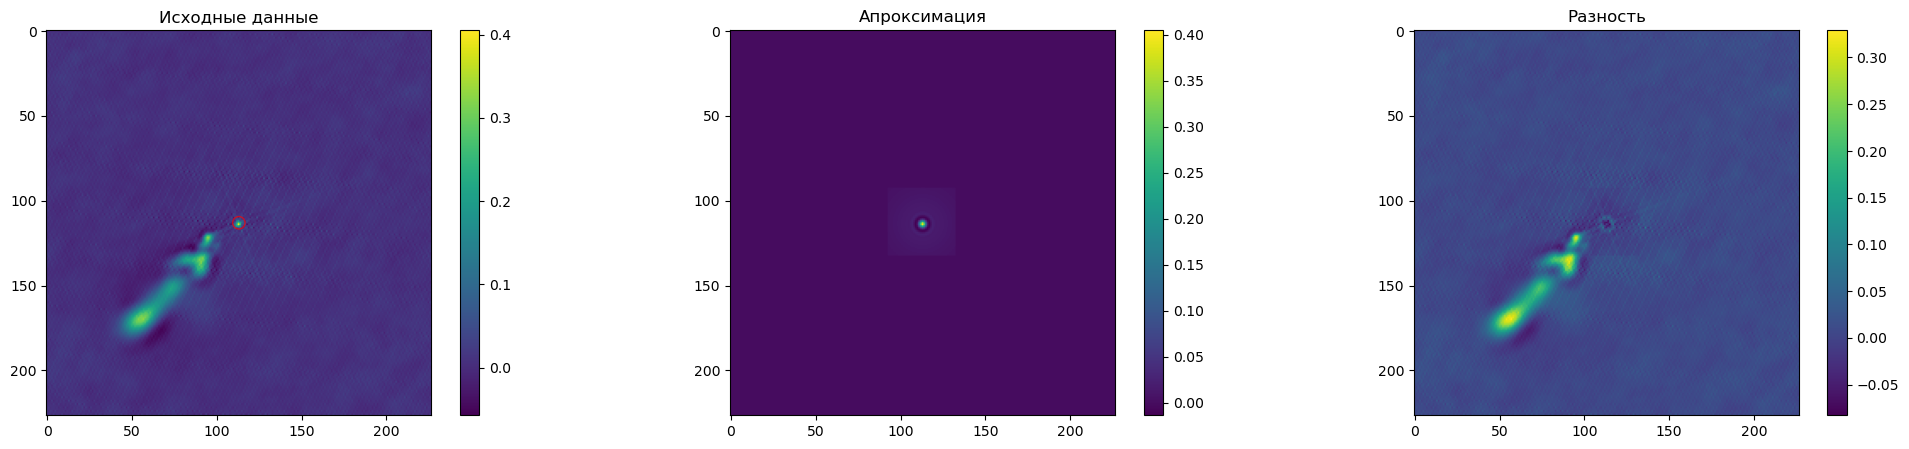

In [3]:
myParams = [( 0,   0, 2001)]
#             (-7.5, -7.5, 18000),
#             (-15, -15, 26000)]

fit, speckle_x, speckle_y, Cn2_values, z, vx, vy = multi_speckle_fit(params=myParams, ydata=data)

# -----------------------------------------------------------
lambda_=500*pow(10, -9) # нм
k = 2*np.pi/lambda_
r0 = pow(0.423*pow(k, 2)*(np.sum(1e-13*np.array(Cn2_values))), -3/5)
print(' ')
print('sum Cn2:', np.sum(1e-13*np.array(Cn2_values)))
print('r0, sm:', 100*r0)
print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)

# ------------ Отрисовка ---------------------------
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
cr = data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0]//2 # центр изображения

fig.colorbar(ax.imshow(data[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax)
ax.set_title('Исходные данные')
fig.colorbar(ax2.imshow(fit[a:fit.shape[0]-a, b:fit.shape[1]-b]), ax=ax2)
ax2.set_title('Апроксимация')
fig.colorbar(ax3.imshow((data-fit)[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax3)
ax3.set_title('Разность')
for i in range(len(speckle_x)):
    ax.scatter(cr+speckle_x[i], cr-speckle_y[i], alpha=0.7, s=80, facecolors='none', edgecolors='r')

print('')

C:\Users\miron\AppData\Local\Temp\ipykernel_11960\608674991.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window=np.ones(dirty.shape, np.bool)


Speckle fitting: 0.0 -0.27533039647577096 2001
Fitted parametrs: 0.02 -0.28 2000.0000005659986
Time: 0.1747
-Cn2: 1.4520619015126563e-12
-max fitted value: 0.41
-max initial value: 0.41

2000.0000005659986
Speckle fitting: 0.0 -0.27533039647577096 2001
Fitted parametrs: -0.02 -0.25 2031.3456561280566
Time: 0.3085
-Cn2: 2.0700716654378693e-12
-max fitted value: 0.41
-max initial value: 0.41

2031.3456561280566
Speckle fitting: 0.0 -0.27533039647577096 2001
Fitted parametrs: -0.01 -0.28 2000.0000000018886
Time: 0.1672
-Cn2: 1.4400186474173802e-12
-max fitted value: 0.41
-max initial value: 0.41

2000.0000000018886
Speckle fitting: -15.418502202643172 -15.693832599118942 10000


C:\Users\miron\AppData\Local\Temp\ipykernel_11960\843721261.py:45: RuntimeWarning: divide by zero encountered in true_divide
  ((gammas[take_closest(a1, z)[0]] - gammas[take_closest(a1, z)][1])/ \
C:\Users\miron\AppData\Local\Temp\ipykernel_11960\843721261.py:45: RuntimeWarning: invalid value encountered in true_divide
  ((gammas[take_closest(a1, z)[0]] - gammas[take_closest(a1, z)][1])/ \
C:\Users\miron\AppData\Local\Temp\ipykernel_11960\843721261.py:49: RuntimeWarning: invalid value encountered in multiply
  res = res * cjk


Fitted parametrs: -15.86 -15.59 29277.32376324697
Time: 0.5487
-Cn2: 4.011126705925774e-13
-max fitted value: 0.33
-max initial value: 0.33

29277.32376324697
Speckle fitting: -4.955947136563877 -2.4779735682819384 10000
Fitted parametrs: -4.91 -2.83 5262.097446171746
Time: 0.4402
-Cn2: 7.844047691520413e-13
-max fitted value: 0.33
-max initial value: 0.33

5262.097446171746
Speckle fitting: -6.057268722466961 -6.332599118942732 10000
Fitted parametrs: -6.44 -6.49 9511.337388245722
Time: 0.4330
-Cn2: 4.4636738876976283e-13
-max fitted value: 0.32
-max initial value: 0.32

9511.337388245722
Speckle fitting: -4.955947136563877 -2.4779735682819384 10000
Fitted parametrs: -4.96 -2.83 10781.249995818698
Time: 0.4141
-Cn2: 4.770449362679465e-13
-max fitted value: 0.33
-max initial value: 0.33

10781.249995818698
Speckle fitting: -5.78193832599119 -5.78193832599119 10000
Fitted parametrs: -6.21 -6.22 8227.327988027308
Time: 1.0773
-Cn2: 7.875465826318657e-13
-max fitted value: 0.32
-max initi

Fitted parametrs: -15.23 -14.58 9597.337178422802
Time: 0.2425
-Cn2: 9.563554678358287e-13
-max fitted value: 0.28
-max initial value: 0.31

9597.337178422802
Speckle fitting: -5.506607929515419 -5.2312775330396475 10000
Fitted parametrs: -5.64 -5.23 8500.000224624442
Time: 0.2147
-Cn2: 6.107991875444604e-13
-max fitted value: 0.24
-max initial value: 0.32

8500.000224624442
Speckle fitting: -10.737885462555067 -10.187224669603523 10000
Fitted parametrs: -10.58 -10.35 9817.31963389317
Time: 0.6217
-Cn2: 4.3539768677989133e-13
-max fitted value: 0.21
-max initial value: 0.22

9817.31963389317
Speckle fitting: -17.070484581497798 -16.244493392070485 10000
Fitted parametrs: -17.07 -16.33 11208.257293660172
Time: 0.3610
-Cn2: 7.543828756395665e-13
-max fitted value: 0.28
-max initial value: 0.32

11208.257293660172
Speckle fitting: -5.78193832599119 -7.709251101321586 10000
Fitted parametrs: -5.78 -7.71 10000.0
Time: 0.1831
-Cn2: 5.858384844212988e-13
-max fitted value: 0.26
-max initial v

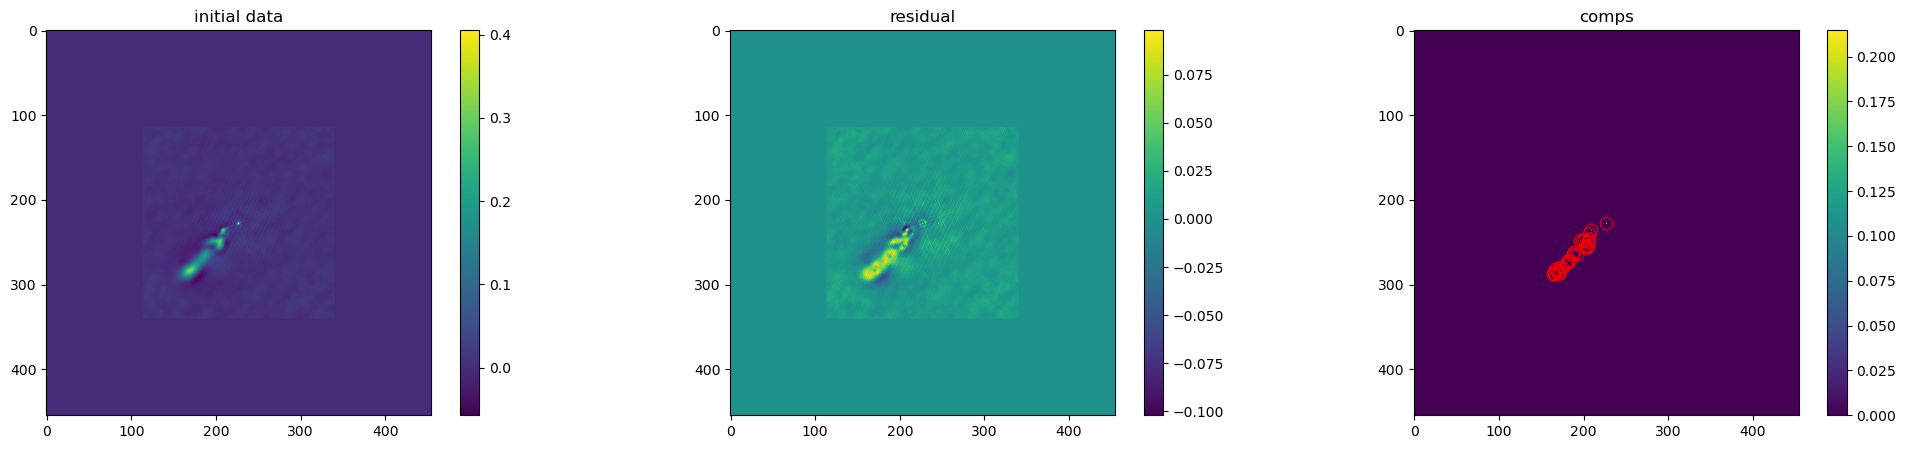

In [4]:
def CLEAN(dirty, gain, thresh, niter):
    global sec_per_frame, latency, delta
    """
    Hogbom clean, https://www.mrao.cam.ac.uk/~bn204/alma/python-clean.html

    :dirty: Изображение, подлежащее деконволюции
    :gain: Коэффициент усиления, т.е. доля самого яркого пикселя, которая удаляется на каждой итерации
    :thresh: Алгоритм прекращается при достижении максимального абсолютного отклонения остатка меньше этого значения
    :niter: Максимальное количество итераций, который необходимо провести, если пороговое значение "thresh" не достигнуто
    """
    comps=np.zeros(dirty.shape)
    res=np.array(dirty) 
    window=np.ones(dirty.shape, np.bool)
    
    tmp = 0
    Cn2 = []
    z = []
    vx = []
    vy = []

    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res[window]), res.shape) # fabs? # нахождение максимального значения
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        t = sec_per_frame * latency
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
     
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [(Vx, Vy, 2001)]
        else:
            myParams = [(Vx, Vy, 10000)]
            
        psf, speckle_x, speckle_y, Cn2v, zv, vxv, vyv = multi_speckle_fit(params=myParams, ydata=res)
        print(zv)
        Cn2.append(Cn2v)
        z.append(zv)
        vx.append(vxv)
        vy.append(vyv)

        
        res -= psf*gain
    
        tmp+=1
#         if np.max(np.fabs(res)) < thresh:
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total interations:', tmp)
    return comps, res, Cn2, z, vx, vy


# =============================================
comps, residual, Cn2, z, vx, vy = CLEAN(data, 0.1, 0.1, 300)
# =============================================
lambda_=650*pow(10, -9) # нм
k = 2*np.pi/lambda_
r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
print(' ')
print('RMS:', np.mean((data - fit)**2))
print('sum Cn2:', np.sum(Cn2))
print('r0, sm:', 100*r0)
print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax2.imshow(residual), ax=ax2)
fig.colorbar(ax3.imshow(comps), ax=ax3)
a_tmp = np.where(comps!=0)
for i in range(len(a_tmp[0])):
    ax3.scatter(a_tmp[1][i], a_tmp[0][i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
ax.set_title('initial data')
ax2.set_title('residual')
ax3.set_title('comps')
print('')

Text(0, 0.5, 'z')

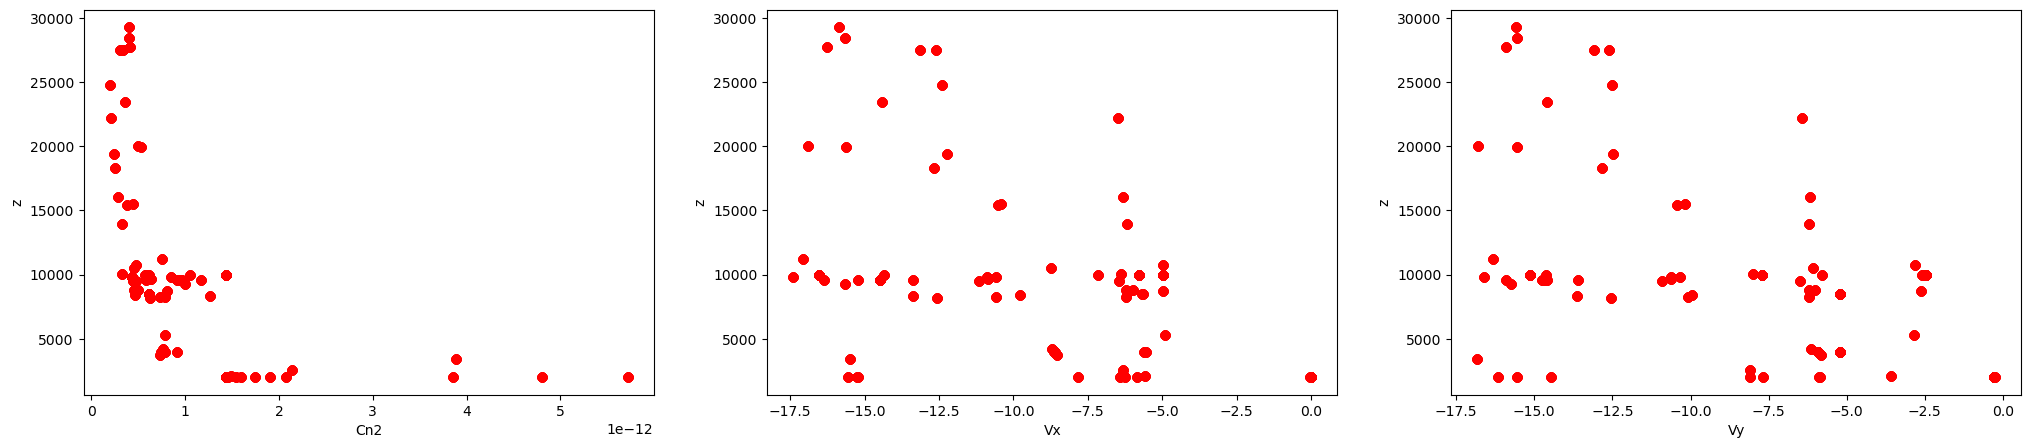

In [5]:
profile1 = np.stack((z, Cn2))
profile1 = profile1[:, profile1[0].argsort()]

profile2 = np.stack((z, vx))
profile2 = profile2[:, profile2[0].argsort()]

profile3 = np.stack((z, vy))
profile3 = profile3[:, profile3[0].argsort()]

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

for i in range(len(profile1[0])):
    ax.scatter(profile1[1], profile1[0], color='red')
    ax2.scatter(profile2[1], profile2[0], color='red')
    ax3.scatter(profile3[1], profile3[0], color='red')
    
ax.set_xlabel('Cn2')
ax.set_ylabel('z')
ax2.set_xlabel('Vx')
ax2.set_ylabel('z')
ax3.set_xlabel('Vy')
ax3.set_ylabel('z')

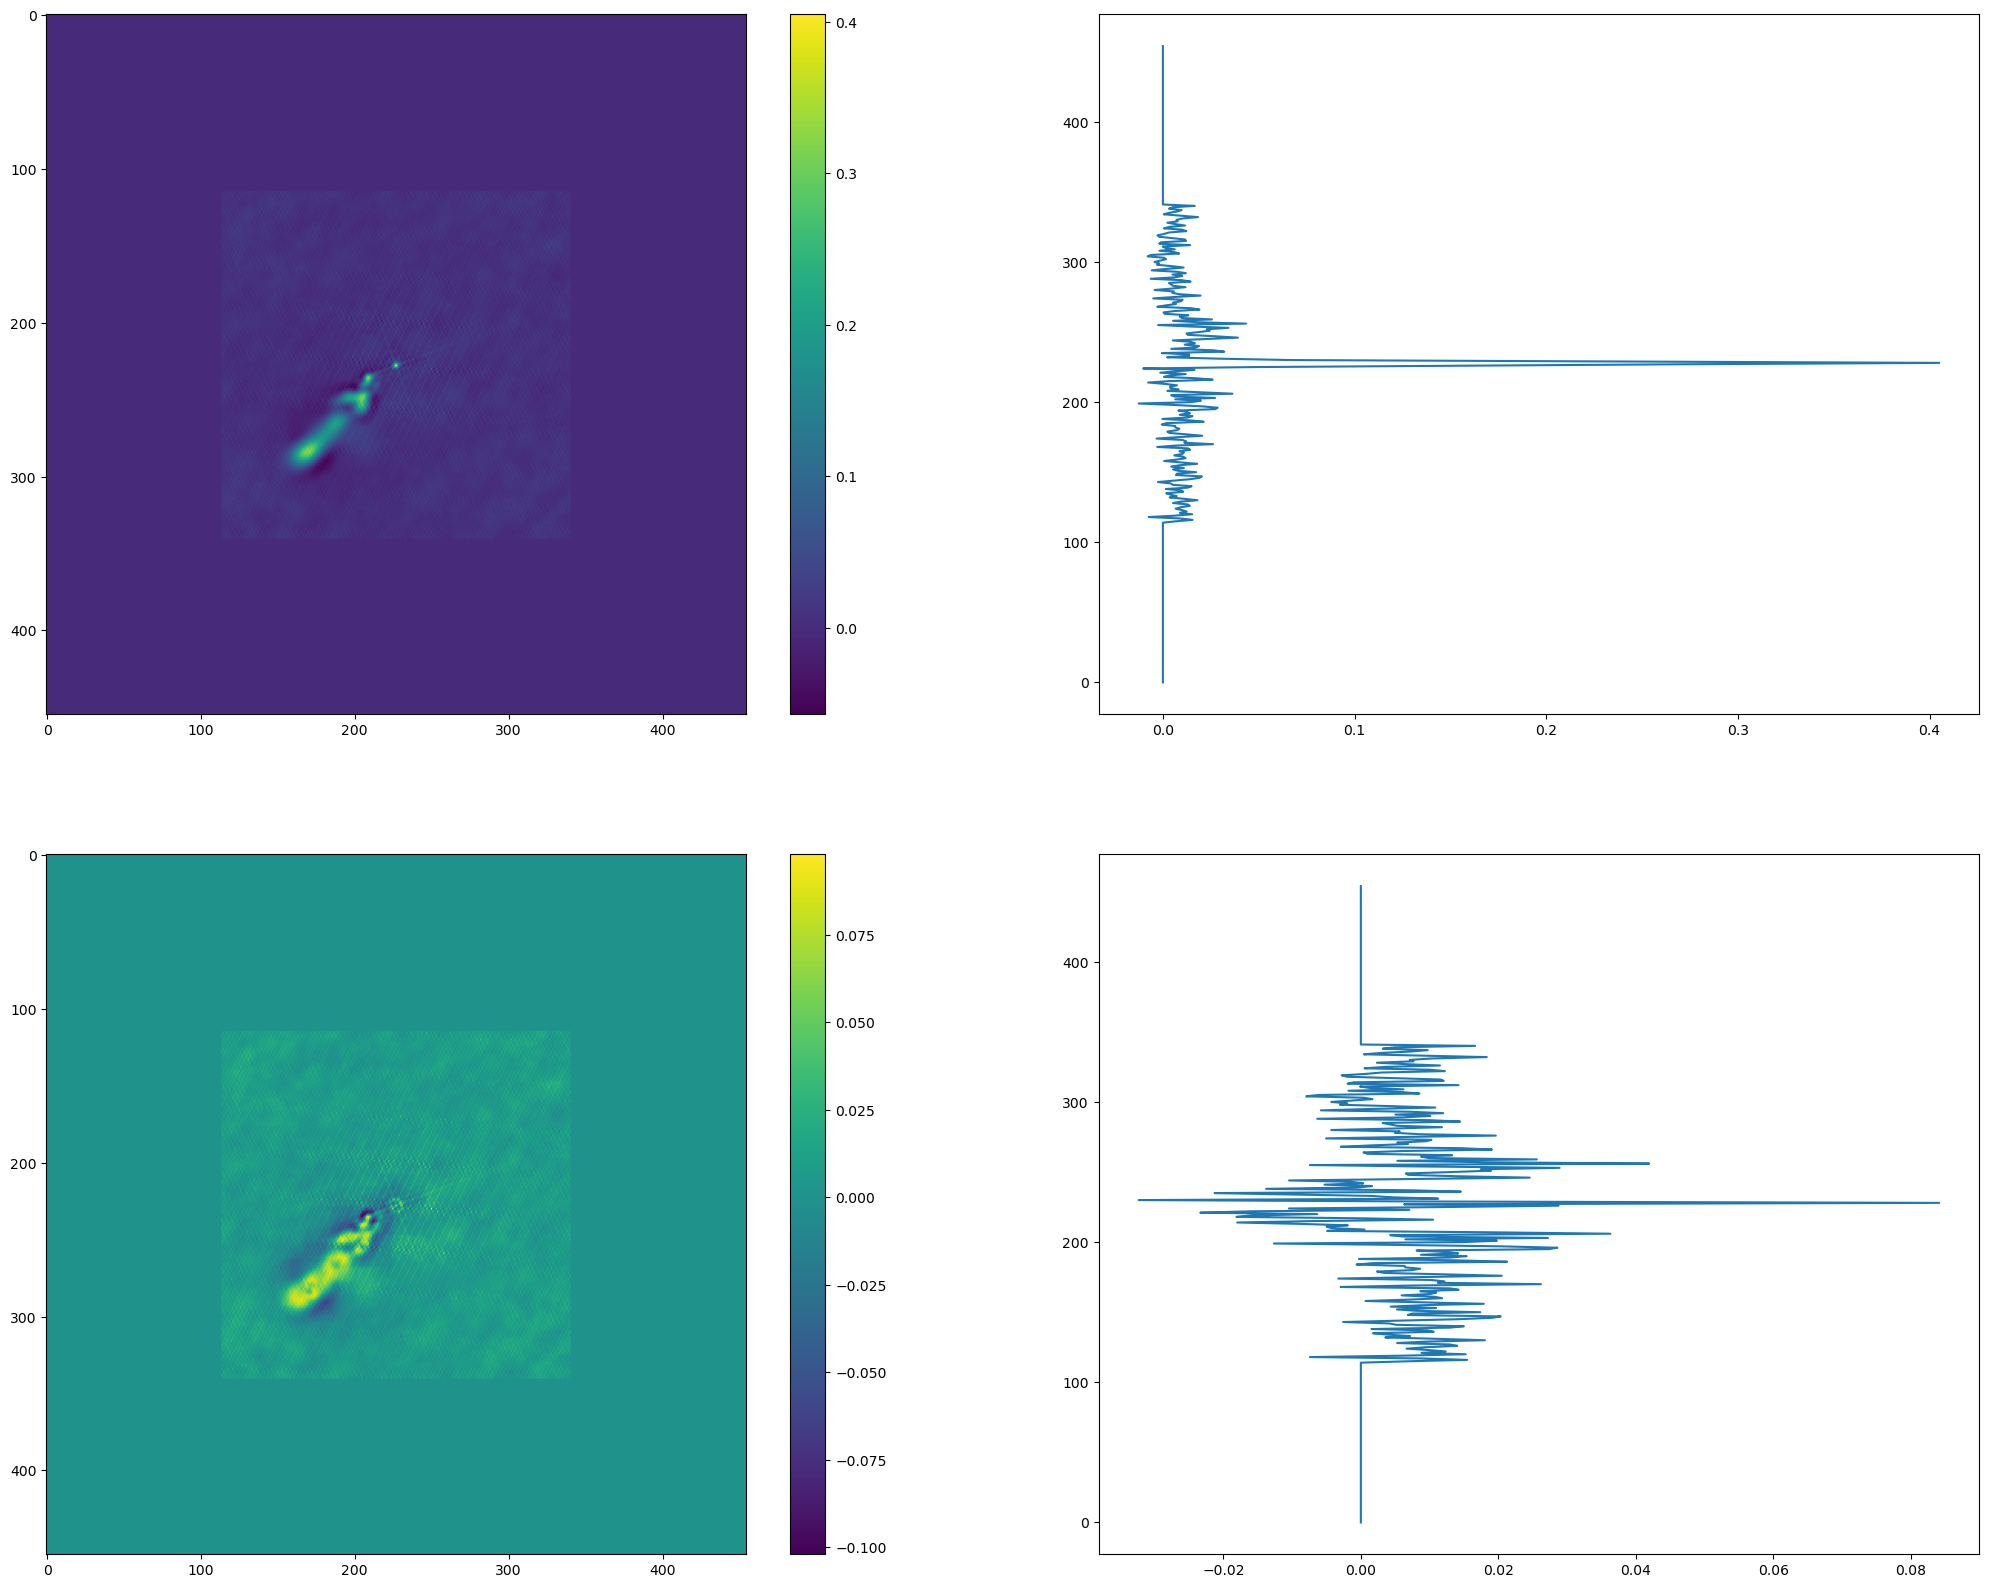

In [6]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 20))

fig.colorbar(ax.imshow(data), ax=ax)
ax2.plot(data[:, 227], range(455))
fig.colorbar(ax3.imshow(residual), ax=ax3)
ax4.plot(residual[:, 227], range(455))